In [8]:
import os
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from get_data.traj_generator import (
  derive_target_velocities,
  derive_target_accelerations
)

CTRL_FREQ  = 30
SEGMENTS   = 4
TOTAL_TIME = 12

In [13]:
def get_stats_for_trajectory(ref_pos):
  ref_vel = derive_target_velocities(ref_pos, CTRL_FREQ)
  ref_acc = derive_target_accelerations(ref_vel, CTRL_FREQ)
  
  mean_vel   = np.mean(np.linalg.norm(ref_vel, axis=1))
  mean_accel = np.mean(np.linalg.norm(ref_acc, axis=1))
  
  # Compute angle between each change in position vector
  angles      = []
  differences = np.diff(ref_pos, axis=0)
  differences /= np.linalg.norm(differences, axis=1, keepdims=True)
    
  for idx in range(differences.shape[0] - 1):
    v1, v2 = differences[idx], differences[idx + 1]
    angle  = np.arccos(v1.dot(v2)) * 180 / np.pi
    angles.append(angle)
    
  return {
    "mean_vel": mean_vel,
    "mean_accel": mean_accel,
    "theta_spread": np.std(angles)
  }

In [14]:
data_dir = 'data'

stats_list = []
for filename in tqdm.tqdm(os.listdir(data_dir)):
    if filename.endswith('.npy'):  # Process only .npy files
        filepath = os.path.join(data_dir, filename)        
        ref_pos  = np.load(filepath)
        stats    = get_stats_for_trajectory(ref_pos)
        stats['sample'] = filename.replace('.npy', '')
        stats_list.append(stats)

# Convert the list of stats dictionaries to a DataFrame
df = pd.DataFrame(stats_list)

  0%|          | 0/18715 [00:00<?, ?it/s]

100%|██████████| 18715/18715 [00:10<00:00, 1728.14it/s]


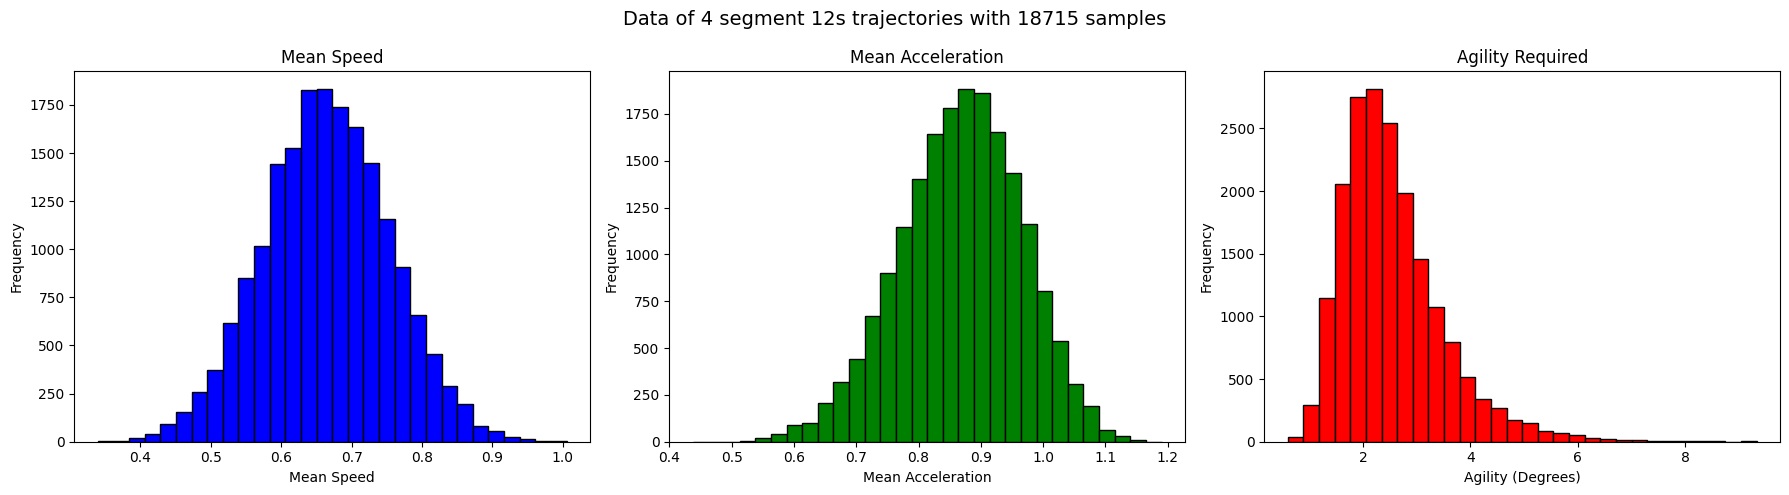

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

titles = ['Mean Speed', 'Mean Acceleration', 'Agility Required']

axs[0].hist(df['mean_vel'], bins=30, color='b', edgecolor='black')
axs[0].set_title(titles[0])
axs[0].set_xlabel('Mean Speed')
axs[0].set_ylabel('Frequency')

axs[1].hist(df['mean_accel'], bins=30, color='g', edgecolor='black')
axs[1].set_title(titles[1])
axs[1].set_xlabel('Mean Acceleration')
axs[1].set_ylabel('Frequency')

axs[2].hist(df['theta_spread'], bins=30, color='r', edgecolor='black')
axs[2].set_title(titles[2])
axs[2].set_xlabel('Agility (Degrees)')
axs[2].set_ylabel('Frequency')

plt.suptitle(f'Data of 4 segment 12s trajectories with {df.shape[0]} samples', fontsize=14)
plt.tight_layout()
plt.show()

In [12]:
max_vel_row = df.loc[df['mean_vel'].idxmax()]
min_vel_row = df.loc[df['mean_vel'].idxmin()]

max_accel_row = df.loc[df['mean_accel'].idxmax()]
min_accel_row = df.loc[df['mean_accel'].idxmin()]

max_theta_spread_row = df.loc[df['theta_spread'].idxmax()]
min_theta_spread_row = df.loc[df['theta_spread'].idxmin()]

print("Row with Maximum Velocity:")
print(max_vel_row)
print("\nRow with Minimum Velocity:")
print(min_vel_row)

print("\nRow with Maximum Acceleration:")
print(max_accel_row)
print("\nRow with Minimum Acceleration:")
print(min_accel_row)

print("\nRow with Maximum Theta Spread:")
print(max_theta_spread_row)
print("\nRow with Minimum Theta Spread:")
print(min_theta_spread_row)

Row with Maximum Velocity:
max_vel         1.005346
max_accel       1.724688
theta_spread      1.2831
sample             18130
Name: 14984, dtype: object

Row with Minimum Velocity:
max_vel         0.339477
max_accel       1.519834
theta_spread    4.929974
sample              5533
Name: 10552, dtype: object

Row with Maximum Acceleration:
max_vel         0.709231
max_accel       1.998783
theta_spread    2.703398
sample              3584
Name: 11365, dtype: object

Row with Minimum Acceleration:
max_vel         0.549389
max_accel       0.940012
theta_spread    2.035572
sample             15014
Name: 18113, dtype: object

Row with Maximum Theta Spread:
max_vel         0.615053
max_accel       1.691242
theta_spread    9.331303
sample             17457
Name: 8563, dtype: object

Row with Minimum Theta Spread:
max_vel         0.833047
max_accel       1.598419
theta_spread    0.602276
sample              4682
Name: 3490, dtype: object
